In [1]:
!pip install datasets==2.16.0

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
  Attempting uninstall: datasets
    Foun

Dataset loaded successfully with 36 classes
Training batches: 21212
Validation batches: 2496
Input batch shape: torch.Size([4, 1, 128, 63])
Labels shape: torch.Size([4])
Visualization saved to 'audio_pipeline_visualization.png'
Audio label: 10
With MFCC, input batch shape: torch.Size([4, 1, 40, 63])


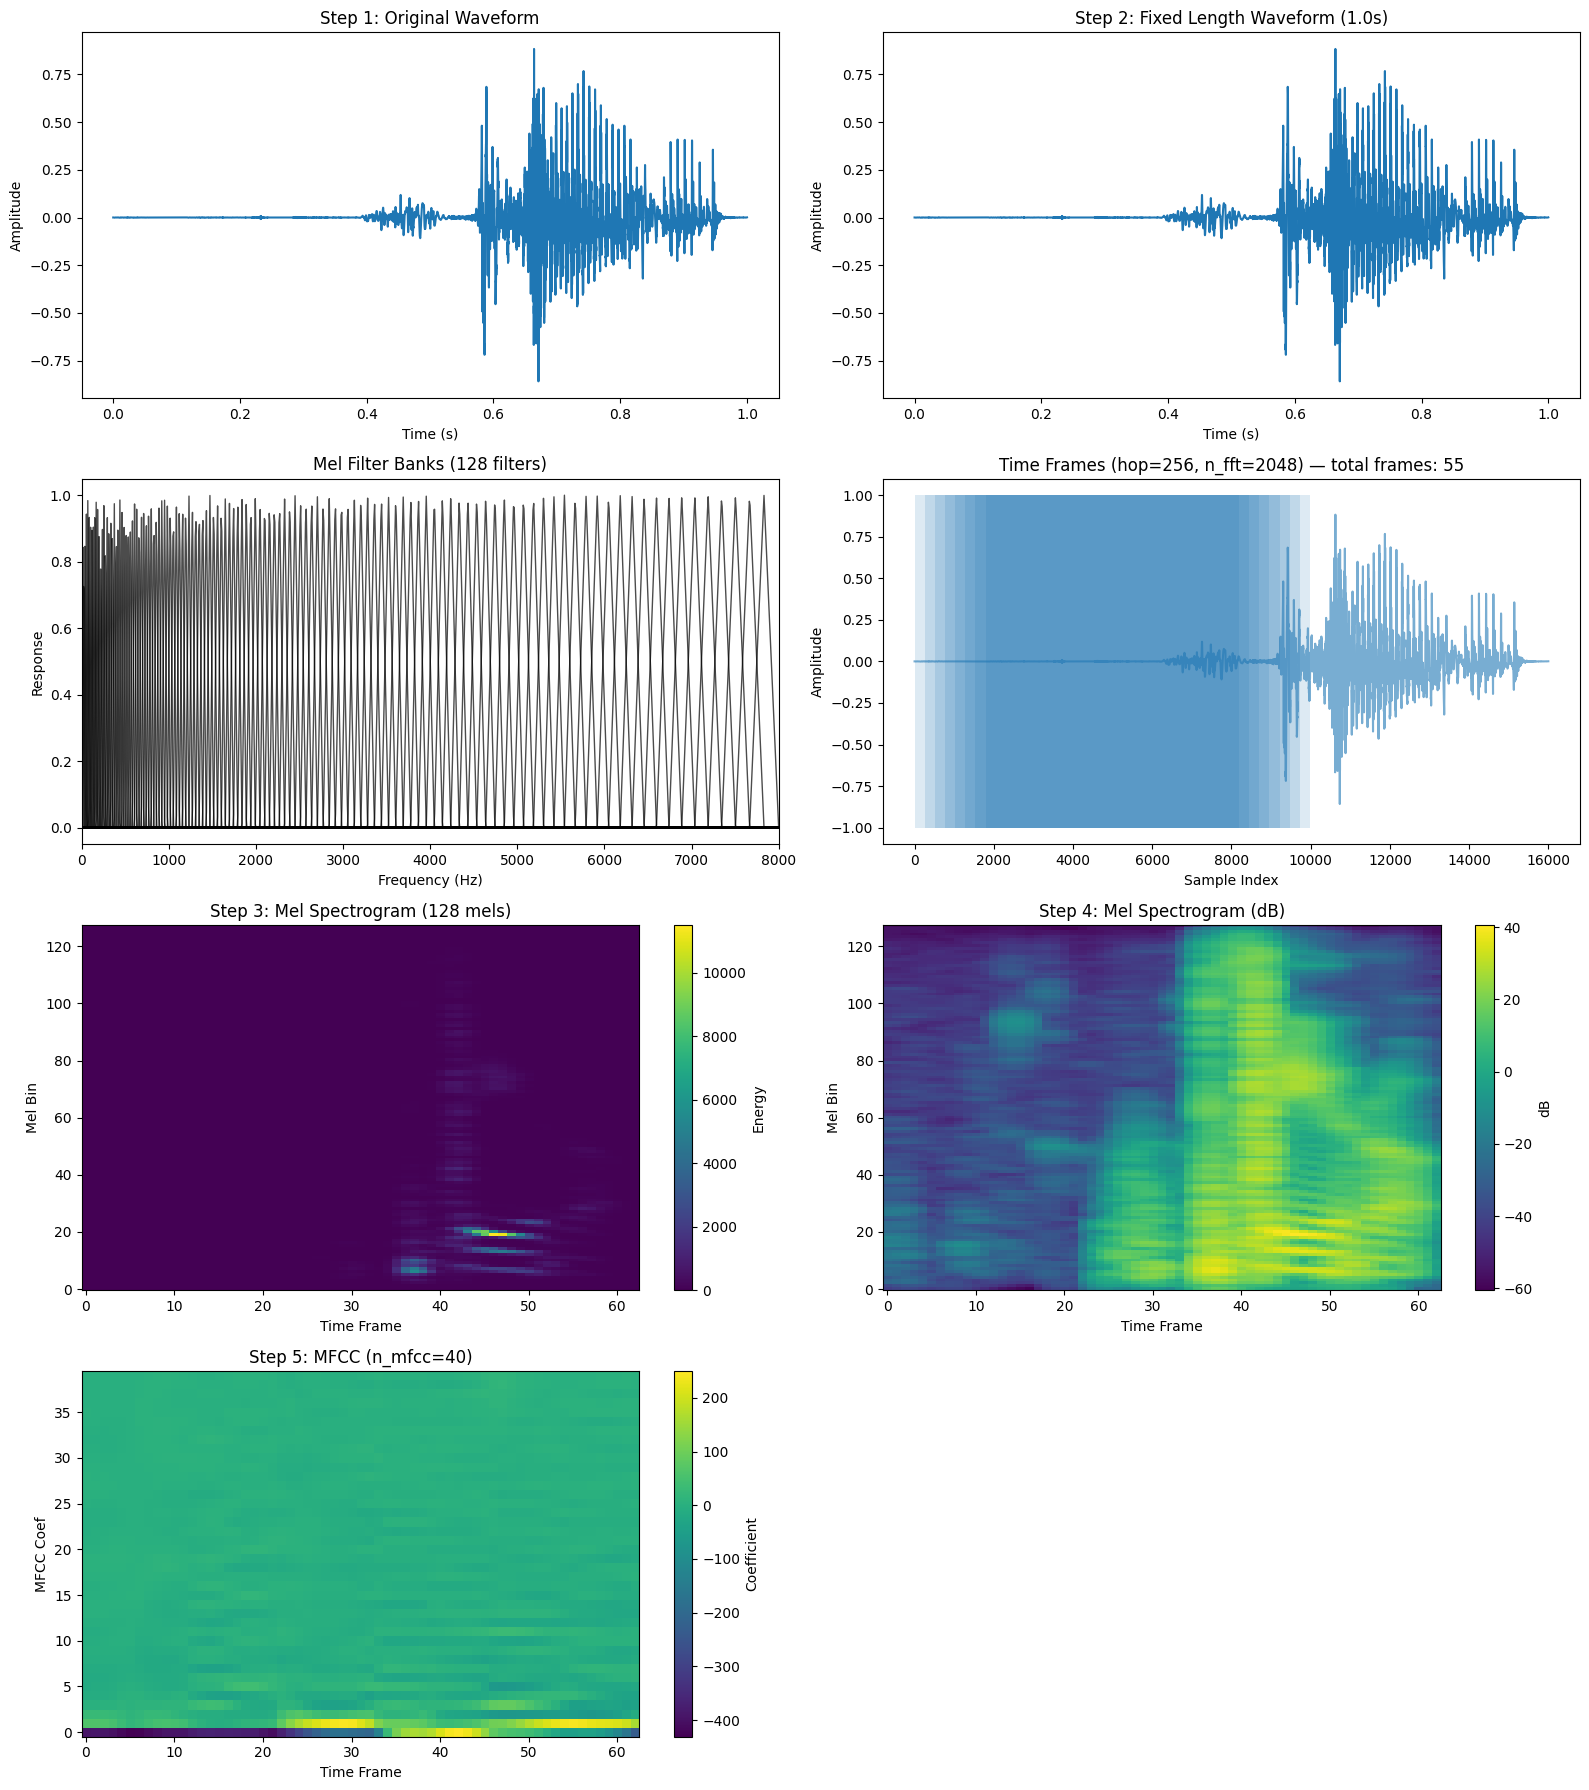

In [9]:
import os
import torch
import numpy as np
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, Resample
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt


class AudioProcessingPipeline(torch.nn.Module):
    """PyTorch Module-based audio processing pipeline."""

    def __init__(
        self,
        target_length=1.0,
        sample_rate=16000,
        n_mels=128,
        n_fft=2048,
        hop_length=256,
        normalize=None,
        output_mfcc=True,
        n_mfcc=40
    ):
        super().__init__()
        self.target_length = target_length
        self.sample_rate = sample_rate
        self.normalize = normalize
        self.output_mfcc = output_mfcc

        # Define the mel spectrogram processor
        self.mel_spec = MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )

        # Amplitude to dB converter
        self.amp_to_db = AmplitudeToDB()

        if output_mfcc:
            self.mfcc_transform = torchaudio.transforms.MFCC(
                sample_rate=sample_rate,
                n_mfcc=n_mfcc,
                melkwargs={
                    'n_fft': n_fft,
                    'hop_length': hop_length,
                    'n_mels': n_mels
                }
            )

    def fix_length(self, waveform, sample_rate):
        """Fixes the length of the audio."""
        length = int(self.target_length * sample_rate)

        if isinstance(waveform, torch.Tensor):
            if length < waveform.size(-1):
                # Truncate
                return waveform[..., :length]
            elif length > waveform.size(-1):
                # Pad with zeros
                return torch.nn.functional.pad(waveform, (0, length - waveform.size(-1)))
            return waveform
        else:
            # Handle numpy arrays
            waveform_tensor = torch.tensor(waveform)
            return self.fix_length(waveform_tensor, sample_rate)

    def forward(self, data):
        """
        Process the input data through the pipeline.

        Args:
            data (dict): Dictionary with 'samples', 'sample_rate', and 'label'

        Returns:
            tuple: (tensor, label) where tensor is the processed mel spectrogram
        """
        # Get samples and ensure it's a tensor
        samples = data['samples']
        sample_rate = data['sample_rate']

        if not isinstance(samples, torch.Tensor):
            waveform = torch.tensor(samples, dtype=torch.float32)
        else:
            waveform = samples

        # Make sure waveform has correct shape [channels, time]
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)

        # Fix audio length
        waveform = self.fix_length(waveform, sample_rate)

        # If MFCC output is requested, use the MFCC transform
        if self.output_mfcc:
            mfcc = self.mfcc_transform(waveform)

            # Apply normalization if specified
            if self.normalize is not None:
                mean, std = self.normalize
                mfcc = (mfcc - mean) / std

            return mfcc, data['label']

        # Generate mel spectrogram
        mel_spec = self.mel_spec(waveform)

        # Convert to decibels
        mel_spec_db = self.amp_to_db(mel_spec)

        # Apply normalization if specified
        if self.normalize is not None:
            mean, std = self.normalize
            mel_spec_db = (mel_spec_db - mean) / std

        return mel_spec_db, data['label']


class HuggingFaceSpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset wrapper for HuggingFace dataset."""

    def __init__(self, hf_dataset, processor=None):
        """
        Args:
            hf_dataset: HuggingFace dataset split
            processor (nn.Module, optional): Processing pipeline module
        """
        self.dataset = hf_dataset
        self.processor = processor
        self.classes = sorted(set(self.dataset['label']))
        self.class_to_idx = {label: i for i, label in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # Create data dict
        data = {
            'samples': np.array(item['audio']['array']).astype(np.float32),
            'sample_rate': item['audio']['sampling_rate'],
            'label': self.class_to_idx[item['label']]
        }

        if self.processor:
            # Process using our pipeline module
            features, label = self.processor(data)
            return features, label

        return data


def load_speech_commands(batch_size=4, num_workers=2, output_mfcc=False, n_mfcc=40):
    """Load Google Speech Commands dataset using HuggingFace and create data loaders."""
    # Load the dataset from HuggingFace
    hf_dataset = load_dataset('google/speech_commands', 'v0.02')

    # Create audio processing pipeline
    processor = AudioProcessingPipeline(
        target_length=1.0,
        sample_rate=16000,
        n_mels=128,
        n_fft=2048,
        hop_length=256,
        output_mfcc=output_mfcc,
        n_mfcc=n_mfcc
    )

    # Create datasets for each split
    train_dataset = HuggingFaceSpeechCommandsDataset(
        hf_dataset['train'],
        processor=processor
    )

    val_dataset = HuggingFaceSpeechCommandsDataset(
        hf_dataset['validation'],
        processor=processor
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, len(train_dataset.classes)


def visualize_pipeline(processor, data, max_frames_to_show=32):
    """
    Visualizes each step of the audio processing pipeline including mel bands,
    time frames, mel spectrogram (linear & dB), and MFCC (linear & dB).

    Args:
        processor: The AudioProcessingPipeline instance
        data: dict with keys 'samples', 'sample_rate', 'label'
        max_frames_to_show: int or None. If int, draw at most this many frame rectangles.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    from matplotlib.patches import Polygon

    # ----- Extract + prepare waveform -----
    samples = data['samples']
    sample_rate = data['sample_rate']

    waveform = torch.tensor(samples, dtype=torch.float32) if not isinstance(samples, torch.Tensor) else samples
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)  # [C=1, T]

    fixed_waveform = processor.fix_length(waveform, sample_rate)

    # ----- Layout: 4 rows x 2 cols (8 subplots) -----
    fig = plt.figure(figsize=(16, 18))
    gs = fig.add_gridspec(4, 2)

    # 1) Raw waveform
    ax1 = fig.add_subplot(gs[0, 0])
    t_raw = np.arange(waveform.size(-1)) / sample_rate
    ax1.plot(t_raw, waveform[0].numpy())
    ax1.set_title('Original Waveform')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')

    # 2) Fixed-length waveform
    ax2 = fig.add_subplot(gs[0, 1])
    t_fix = np.arange(fixed_waveform.size(-1)) / sample_rate
    ax2.plot(t_fix, fixed_waveform[0].numpy())
    ax2.set_title(f'Fixed Length Waveform ({processor.target_length}s)')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')

    # 3) Mel filter banks (schematic)
    ax3 = fig.add_subplot(gs[1, 0])
    n_mels = processor.mel_spec.n_mels
    sr = processor.sample_rate

    def hz_to_mel(f): return 2595 * np.log10(1 + f / 700)
    def mel_to_hz(m): return 700 * (10 ** (m / 2595) - 1)

    f_min, f_max = 0, sr / 2
    mel_pts = np.linspace(hz_to_mel(f_min), hz_to_mel(f_max), n_mels + 2)
    hz_pts = mel_to_hz(mel_pts)
    freq_bins = np.linspace(0, sr / 2, 1000)

    for i in range(n_mels):
        f_l, f_c, f_r = hz_pts[i], hz_pts[i + 1], hz_pts[i + 2]
        resp = np.zeros_like(freq_bins)
        # rising edge
        mask = (freq_bins >= f_l) & (freq_bins < f_c)
        resp[mask] = (freq_bins[mask] - f_l) / (f_c - f_l)
        # falling edge
        mask = (freq_bins >= f_c) & (freq_bins < f_r)
        resp[mask] = (f_r - freq_bins[mask]) / (f_r - f_c)
        ax3.plot(freq_bins, resp, color='black', alpha=0.7, linewidth=1.0)


    ax3.set_title(f'Mel Filter Banks ({n_mels} filters)')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Response')
    ax3.set_xlim(0, sr / 2)

    # 4) Time frames overlay
    ax4 = fig.add_subplot(gs[1, 1])
    hop = processor.mel_spec.hop_length
    n_fft = processor.mel_spec.n_fft
    n_frames = max(0, (fixed_waveform.size(1) - n_fft) // hop + 1)
    ax4.plot(fixed_waveform[0].numpy(), alpha=0.6)

    frame_indices = np.arange(0, n_frames) * hop
    if max_frames_to_show is None:
        use_indices = frame_indices
    else:
        use_indices = frame_indices[:max(0, min(len(frame_indices), max_frames_to_show))]

    # draw translucent windows showing each analysis frame length n_fft
    for i, idx in enumerate(use_indices):
        rect = plt.Rectangle((idx, -1.0), n_fft, 2.0, alpha=0.15)
        ax4.add_patch(rect)

    ax4.set_title(f'Time Frames (hop={hop}, n_fft={n_fft}) — total frames: {n_frames}')
    ax4.set_xlabel('Sample Index')
    ax4.set_ylabel('Amplitude')
    ax4.set_ylim(-1.1, 1.1)

    # 5) Mel spectrogram (linear)
    mel_spec = processor.mel_spec(fixed_waveform)  # [C, n_mels, T]
    ax5 = fig.add_subplot(gs[2, 0])
    im5 = ax5.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', interpolation='none')
    ax5.set_title(f'Mel Spectrogram ({n_mels} mels)')
    ax5.set_xlabel('Time Frame')
    ax5.set_ylabel('Mel Bin')
    fig.colorbar(im5, ax=ax5, label='Energy')

    # 6) Mel spectrogram (dB)
    mel_spec_db = processor.amp_to_db(mel_spec)
    ax6 = fig.add_subplot(gs[2, 1])
    im6 = ax6.imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower', interpolation='none')
    ax6.set_title('Mel Spectrogram (dB)')
    ax6.set_xlabel('Time Frame')
    ax6.set_ylabel('Mel Bin')
    fig.colorbar(im6, ax=ax6, label='dB')

    # 7) MFCC (linear)
    # Use processor.mfcc_transform if available; otherwise create a default one
    if hasattr(processor, 'mfcc_transform') and processor.mfcc_transform is not None:
        mfcc_tx = processor.mfcc_transform
    else:
        mfcc_tx = torchaudio.transforms.MFCC(
            sample_rate=processor.sample_rate,
            n_mfcc=40,
            melkwargs={
                'n_fft': processor.mel_spec.n_fft,
                'hop_length': processor.mel_spec.hop_length,
                'n_mels': processor.mel_spec.n_mels
            }
        )

    mfcc = mfcc_tx(fixed_waveform)  # [C, n_mfcc, T]
    ax7 = fig.add_subplot(gs[3, 0])
    im7 = ax7.imshow(mfcc[0].numpy(), aspect='auto', origin='lower', interpolation='none')
    ax7.set_title(f'MFCC (n_mfcc={mfcc.size(1)})')
    ax7.set_xlabel('Time Frame')
    ax7.set_ylabel('MFCC Coef')
    fig.colorbar(im7, ax=ax7, label='Coefficient')

    plt.tight_layout()
    return fig


def main():
    """Example usage of loading and preprocessing the dataset."""
    # Load dataset and create data loaders
    train_loader, val_loader, num_classes = load_speech_commands(batch_size=4)

    print(f"Dataset loaded successfully with {num_classes} classes")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")

    # Example of iterating through one batch
    for inputs, labels in train_loader:
        print(f"Input batch shape: {inputs.shape}")
        print(f"Labels shape: {labels.shape}")
        break  # Just show the first batch

    # Visualize the pipeline for one example
    # Get the dataset and processor
    hf_dataset = load_dataset('google/speech_commands', 'v0.02')
    processor = AudioProcessingPipeline(
        target_length=1.0,
        sample_rate=16000,
        n_mels=128,
        n_fft=2048,
        hop_length=256
    )

    # Get one example with the label "yes" for better visualization
    for item in hf_dataset['train']:
        if item['label'] == 'yes':
            break

    data = {
        'samples': np.array(item['audio']['array']).astype(np.float32),
        'sample_rate': item['audio']['sampling_rate'],
        'label': item['label']
    }

    # Visualize
    fig = visualize_pipeline(processor, data)
    plt.savefig('audio_pipeline_visualization.png', dpi=150)
    print(f"Visualization saved to 'audio_pipeline_visualization.png'")
    print(f"Audio label: {data['label']}")

    #with mfcc
    train_loader, val_loader, num_classes = load_speech_commands(output_mfcc=True)

    # Example of iterating through one batch
    for inputs, labels in train_loader:
        print(f"With MFCC, input batch shape: {inputs.shape}")
        break

if __name__ == "__main__":
    main()